# Prototyping Ampel T0 filters using the DevAlertProcessor


This notebooks demonstrate how T0 filters can be protoyped and tested using the `DevAlertProcessor`. This class allows to apply Ampel filters directly on the nightly alert tarballs, without having to rely on the full Ampel inatallation.

## Code your filter

Let's use a very simple filter, accepting alerts which are positive subtraction (brighter than reference) and cutting on number of previous detections, real-bogus and star-galaxy score, and with a limt on the magnitude.

In [1]:
import logging
from ampel.abstract.AbsAlertFilter import AbsAlertFilter

class SimpleFilter(AbsAlertFilter):
    version=1.0
    
    def __init__(self, on_match_t2_units, base_config=None, run_config=None, logger=None):
        
        self.mag_th     = run_config['MagTh']
        self.min_ndet   = run_config['MinNDet']
        self.rb_th      = run_config['RbTh']
        self.sg_th      = run_config['Sg1Th']
        self.on_match_t2_units = on_match_t2_units
    
    def apply(self, ampel_alert):

        # cut on properties of current detection:
        latest = ampel_alert.pps[0]
        if not (latest['isdiffpos'] == 't' or latest['isdiffpos'] == '1'):
            return None
        if latest['rb']<self.rb_th:
            return None
        if latest['magpsf']>self.mag_th:
            return None
        
        sg1 = latest.get('sgscore1')
        sgscore = sg1 if (not sg1 is None) else latest.get('sgscore')    # fix for older alert schema
        if sgscore>self.sg_th:
            return None
        
        # cut on number of previous detections
        if len(ampel_alert.pps)<self.min_ndet:
            return None
        
        # if we arrived here we take it
        return self.on_match_t2_units

## Instantiate your filter

now we create an instance of `SimpleFilter`, settin the `run_config` parameters and the T2 (science level) modules we want to execute on the alert passing the filter. For testing purposes, we set *really* loose thresholds. 

In [2]:
my_config = {
    'MagTh': 25.,
    'MinNDet': 0,
    'RbTh': 0.,
    'Sg1Th': 0.,
    }
my_filter = SimpleFilter(on_match_t2_units = ['SNCOSMO'], run_config = my_config)


## Run _DevAlertProcessor_ on tarball

Finally we use the `DevAlertProcessor` to apply the filter to a tarbal with the alerts. To be able to later visualize the alerts that were accepted / rejected, we set the `use_dev_alerts` flag. This will tell the `DevAlertProcessor` to use cast the avro packages to `DevAmpelAlert`, a subclass of the `AmpelAlert` class used in production that retains the image cutouts.

**Tip:** The number of alerts ingested can be limted with the `iter_max` parameters (there are only 22 alerts in the test file we are using). The number of alerts processed is returned by the `process_tar` method.

In [3]:
from ampel.pipeline.t0.DevAlertProcessor import DevAlertProcessor

logging.getLogger()

dap = DevAlertProcessor(my_filter, use_dev_alerts = True)
n_processed = dap.process_tar('../alerts/recent_alerts.tar.gz', iter_max = 22)

2018-06-15 11:08:10 INFO + Ingesting 522193343615015003 (objectId: ZTF18aayhxzx)
2018-06-15 11:08:10 INFO - Rejecting 522193343315015006 (objectId: ZTF18aayhyhx)
2018-06-15 11:08:10 INFO - Rejecting 522193343315010000 (objectId: ZTF18aayhyhy)
2018-06-15 11:08:10 INFO - Rejecting 522193343315015001 (objectId: ZTF18aaxmirj)
2018-06-15 11:08:10 INFO - Rejecting 522193343315015000 (objectId: ZTF18aayhyhz)
2018-06-15 11:08:10 INFO - Rejecting 522193343215015012 (objectId: ZTF18aayhyjt)
2018-06-15 11:08:10 INFO - Rejecting 522193343215015014 (objectId: ZTF18aayhyjy)
2018-06-15 11:08:10 INFO - Rejecting 522193343215010009 (objectId: ZTF18aayhyjx)
2018-06-15 11:08:10 INFO - Rejecting 522193343215015009 (objectId: ZTF18aayhyjw)
2018-06-15 11:08:10 INFO - Rejecting 522193343215015006 (objectId: ZTF18aayhyju)
2018-06-15 11:08:10 INFO - Rejecting 522193343215015013 (objectId: ZTF18aaxxewy)
2018-06-15 11:08:10 INFO - Rejecting 522193343215015004 (objectId: ZTF18aayhyjs)
2018-06-15 11:08:10 INFO - R

## Accessing the results

Once the alerts have been processed, both the accepted and the rejected ones can be accessed from the `DevAlertProccessor` using the `get_accepted_alerts` and `get_rejected_alerts` respectively. This methods return the lists of `DevAmpelAlert` or `AmpelAlert` object, depending on the `use_dev_alerts` flag.

In [4]:
accepted = dap.get_accepted_alerts()
rejected = dap.get_rejected_alerts()
print ("%d alerts accepted by the filter (%.2f precent)"%(len(accepted), 100*len(accepted)/n_processed))
print ("%d alerts rejected by the filter (%.2f precent)"%(len(rejected), 100*len(rejected)/n_processed))
print (accepted)

3 alerts accepted by the filter (13.64 precent)
19 alerts rejected by the filter (86.36 precent)
[<ampel.base.DevAmpelAlert.DevAmpelAlert object at 0x7fe7204bc7f0>, <ampel.base.DevAmpelAlert.DevAmpelAlert object at 0x7fe720426780>, <ampel.base.DevAmpelAlert.DevAmpelAlert object at 0x7fe7203d6ef0>]


## Visualizing the Alerts

Using the `AmpelAlertPlotter` class we can visualize the content of the alerts. 

2018-06-15 11:08:10 INFO Initialized AmpelAlertPlotter in interactive mode.


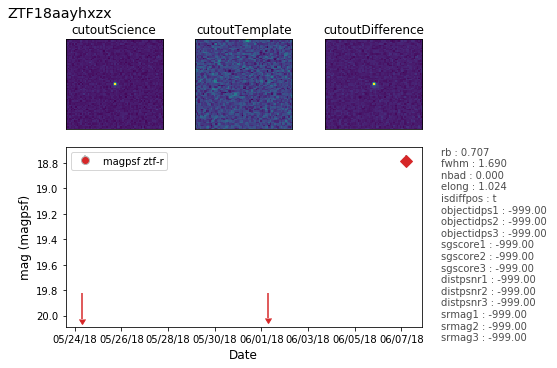

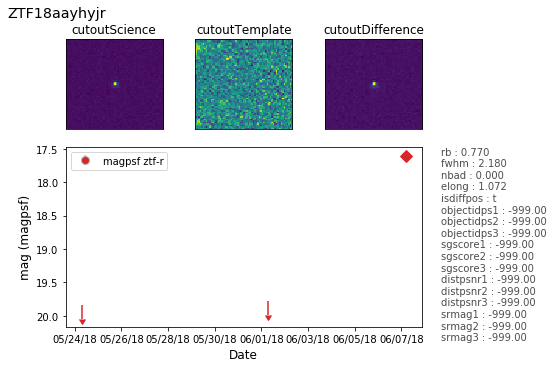

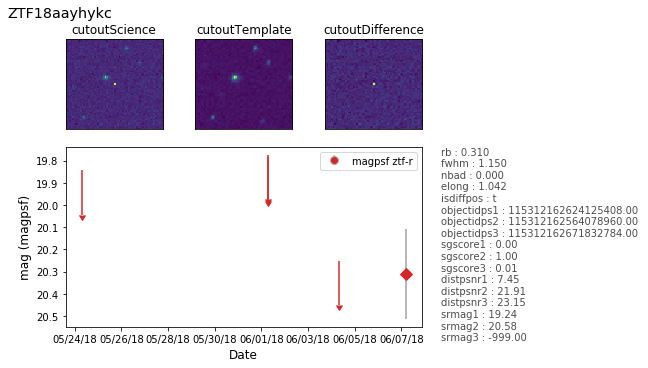

In [5]:
from ampel.view.AmpelAlertPlotter import AmpelAlertPlotter

interactive_plotter = AmpelAlertPlotter(interactive = True)

for accepted_alert in accepted:
    interactive_plotter.summary_plot(accepted_alert)

### notes on AmpelAlertPlotter

For this example we have instatiated the `AmpelAlertPlotter` in interactive mode setting `interactive = True`. All the plots will be show to the user. To inspect more than a few alerts, we can unseet the `interactive` flag so that the plot will be saved to a specified directory.

In this case we will create plots for a random sample of rejected alerts and dump them pngs in `/tmp/rejected`.

In [6]:

silent_plotter = AmpelAlertPlotter(interactive = False, plot_dir = "/tmp/rejected")

import random
for rejected_alert in random.sample(rejected, 2):
    silent_plotter.scatter_plot(rejected_alert, "jd", "rb")                  # generic scatter plot (rb trend here)
    silent_plotter.plot_cutout(rejected_alert, 'cutoutScience', cb = True)   # your favourite cutout
    silent_plotter.plot_lc(rejected_alert)                                   # just plot the light curve
    silent_plotter.summary_plot(rejected_alert, ps1_cutout=False)            # Mickael's nice summary plot.



2018-06-15 11:08:11 INFO Initialized AmpelAlertPlotter in bash-mode. Plots will be saved to /tmp/rejected.
2018-06-15 11:08:11 INFO current figure saved to /tmp/rejected/scatter_jd_rbZTF18aayhxzy.png
2018-06-15 11:08:11 INFO current figure saved to /tmp/rejected/cutoutScience_ZTF18aayhxzy.png
2018-06-15 11:08:11 INFO current figure saved to /tmp/rejected/lc_ZTF18aayhxzy.png
2018-06-15 11:08:12 INFO current figure saved to /tmp/rejected/summary_ZTF18aayhxzy.png
2018-06-15 11:08:12 INFO current figure saved to /tmp/rejected/scatter_jd_rbZTF18aayhyhy.png
2018-06-15 11:08:12 INFO current figure saved to /tmp/rejected/cutoutScience_ZTF18aayhyhy.png
2018-06-15 11:08:12 INFO current figure saved to /tmp/rejected/lc_ZTF18aayhyhy.png
2018-06-15 11:08:12 INFO current figure saved to /tmp/rejected/summary_ZTF18aayhyhy.png


## Filter tuning: running _DevAlertProcessor_ on previously accepted alerts

A way to fine-tune the filters is to start from a loose configuration and iteratively tightening the cuts untill the sample of accepted alerts has reached the desired purity. In this case we scan the real-bogus parameter threshold.

In [8]:
import numpy as np

prev_run_accepted = accepted
recursive_dap = DevAlertProcessor(my_filter)
for rb in np.arange(0, 1, 0.1):
    
    # update filter configuration
    my_filter.rb_th = rb
    recursive_dap._alert_filter = my_filter
    
    # run on the alerts that passed previous version of the filter
    recursive_dap.process_loaded_alerts(prev_run_accepted)
    new_accepted = recursive_dap.get_accepted_alerts()
    
    # print some stats
    print ("running with a RB threshold of %.2f"%rb)
    print ("%d accepted alerts during previous iteration."%len(prev_run_accepted))
    rbs = [a.pps[0]['rb'] for a in new_accepted]
    print ("RB of accepted alerts: %s"%(", ".join(["%.2f"%rrbb for rrbb in rbs])))
    
    # make plots in dedicated directory
    silent_plotter = AmpelAlertPlotter(interactive = False, plot_dir = "/tmp/rbtest_rb%0.1f"%rb)
    for aa in new_accepted:
        silent_plotter.summary_plot(aa)
    
    prev_run_accepted = new_accepted
    

2018-06-15 11:11:04 INFO + Ingesting 522193343615015003 (objectId: ZTF18aayhxzx)
2018-06-15 11:11:04 INFO + Ingesting 522193343215015000 (objectId: ZTF18aayhyjr)
2018-06-15 11:11:04 INFO + Ingesting 522193343215015003 (objectId: ZTF18aayhykc)
2018-06-15 11:11:04 INFO 3 alert(s) processed (time required: 0s)
running with a RB threshold of 0.00
3 accepted alerts during previous iteration.
RB of accepted alerts: 0.71, 0.77, 0.31
2018-06-15 11:11:04 INFO Initialized AmpelAlertPlotter in bash-mode. Plots will be saved to /tmp/rbtest_rb0.0.
2018-06-15 11:11:04 INFO current figure saved to /tmp/rbtest_rb0.0/summary_ZTF18aayhxzx.png
2018-06-15 11:11:04 INFO current figure saved to /tmp/rbtest_rb0.0/summary_ZTF18aayhyjr.png
2018-06-15 11:11:04 INFO current figure saved to /tmp/rbtest_rb0.0/summary_ZTF18aayhykc.png
2018-06-15 11:11:04 INFO + Ingesting 522193343615015003 (objectId: ZTF18aayhxzx)
2018-06-15 11:11:04 INFO + Ingesting 522193343215015000 (objectId: ZTF18aayhyjr)
2018-06-15 11:11:04 I